# Whole Pipeline

Now that we have separately addressed the different modules of the pipeline, let's put them all together in a single pipe.

1. Load the image;
2. Find the liver regions;
3. Find structures in Sox9 staining (ducts, vessels, Sox9+ cells, not well stained areas);
4. Find portal regions.

After this, we should look into generating tables with the information describing each region.

In [1]:
from pathlib import Path

import pyclesperanto_prototype as cle

from gulliver.io import get_image, add_labels, get_channel_from_zarr
from gulliver.segmenter import (
    find_structures,
    segment_liver,
    clean_segmentations,
    add_veins,
)

cle.select_device("RTX")
print(cle.get_device().name)

c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
DATA_DIR = Path("../data/N1 B9-2 10x.czi")

image = get_image(DATA_DIR, 0)

zarr image already exists


Once the image is loaded, we should first look for structures in the Sox9 channel.

In [3]:
sox9_channel = get_channel_from_zarr(image, "Sox9")
gs_channel = get_channel_from_zarr(image, "GS")
elastin_channel = get_channel_from_zarr(image, "elastin")
dapi_channel = get_channel_from_zarr(image, "DAPI")

In [4]:
segmentations = find_structures(
    sox9_channel,
    gs_channel,
    elastin_channel,
    dapi_channel,
    chunk_shape=(5 * 1024, 5 * 7024),
)

We will then look for liver regions in the DAPI channel and use this to remove signal from outside the livers.

In [5]:
liver = segmentations.create_group("liver")
liver.create_dataset(
    "labels",
    data=segment_liver(get_channel_from_zarr(image, "DAPI")),
)

<zarr.core.Array '/liver/labels' (23733, 5670) int32>

In [6]:
clean_segmentations(segmentations)

Finally, we should look for lumenized structures, classify veins and use the elastin positive structures to clean out the Sox9 objects.

In [7]:
add_veins(segmentations)

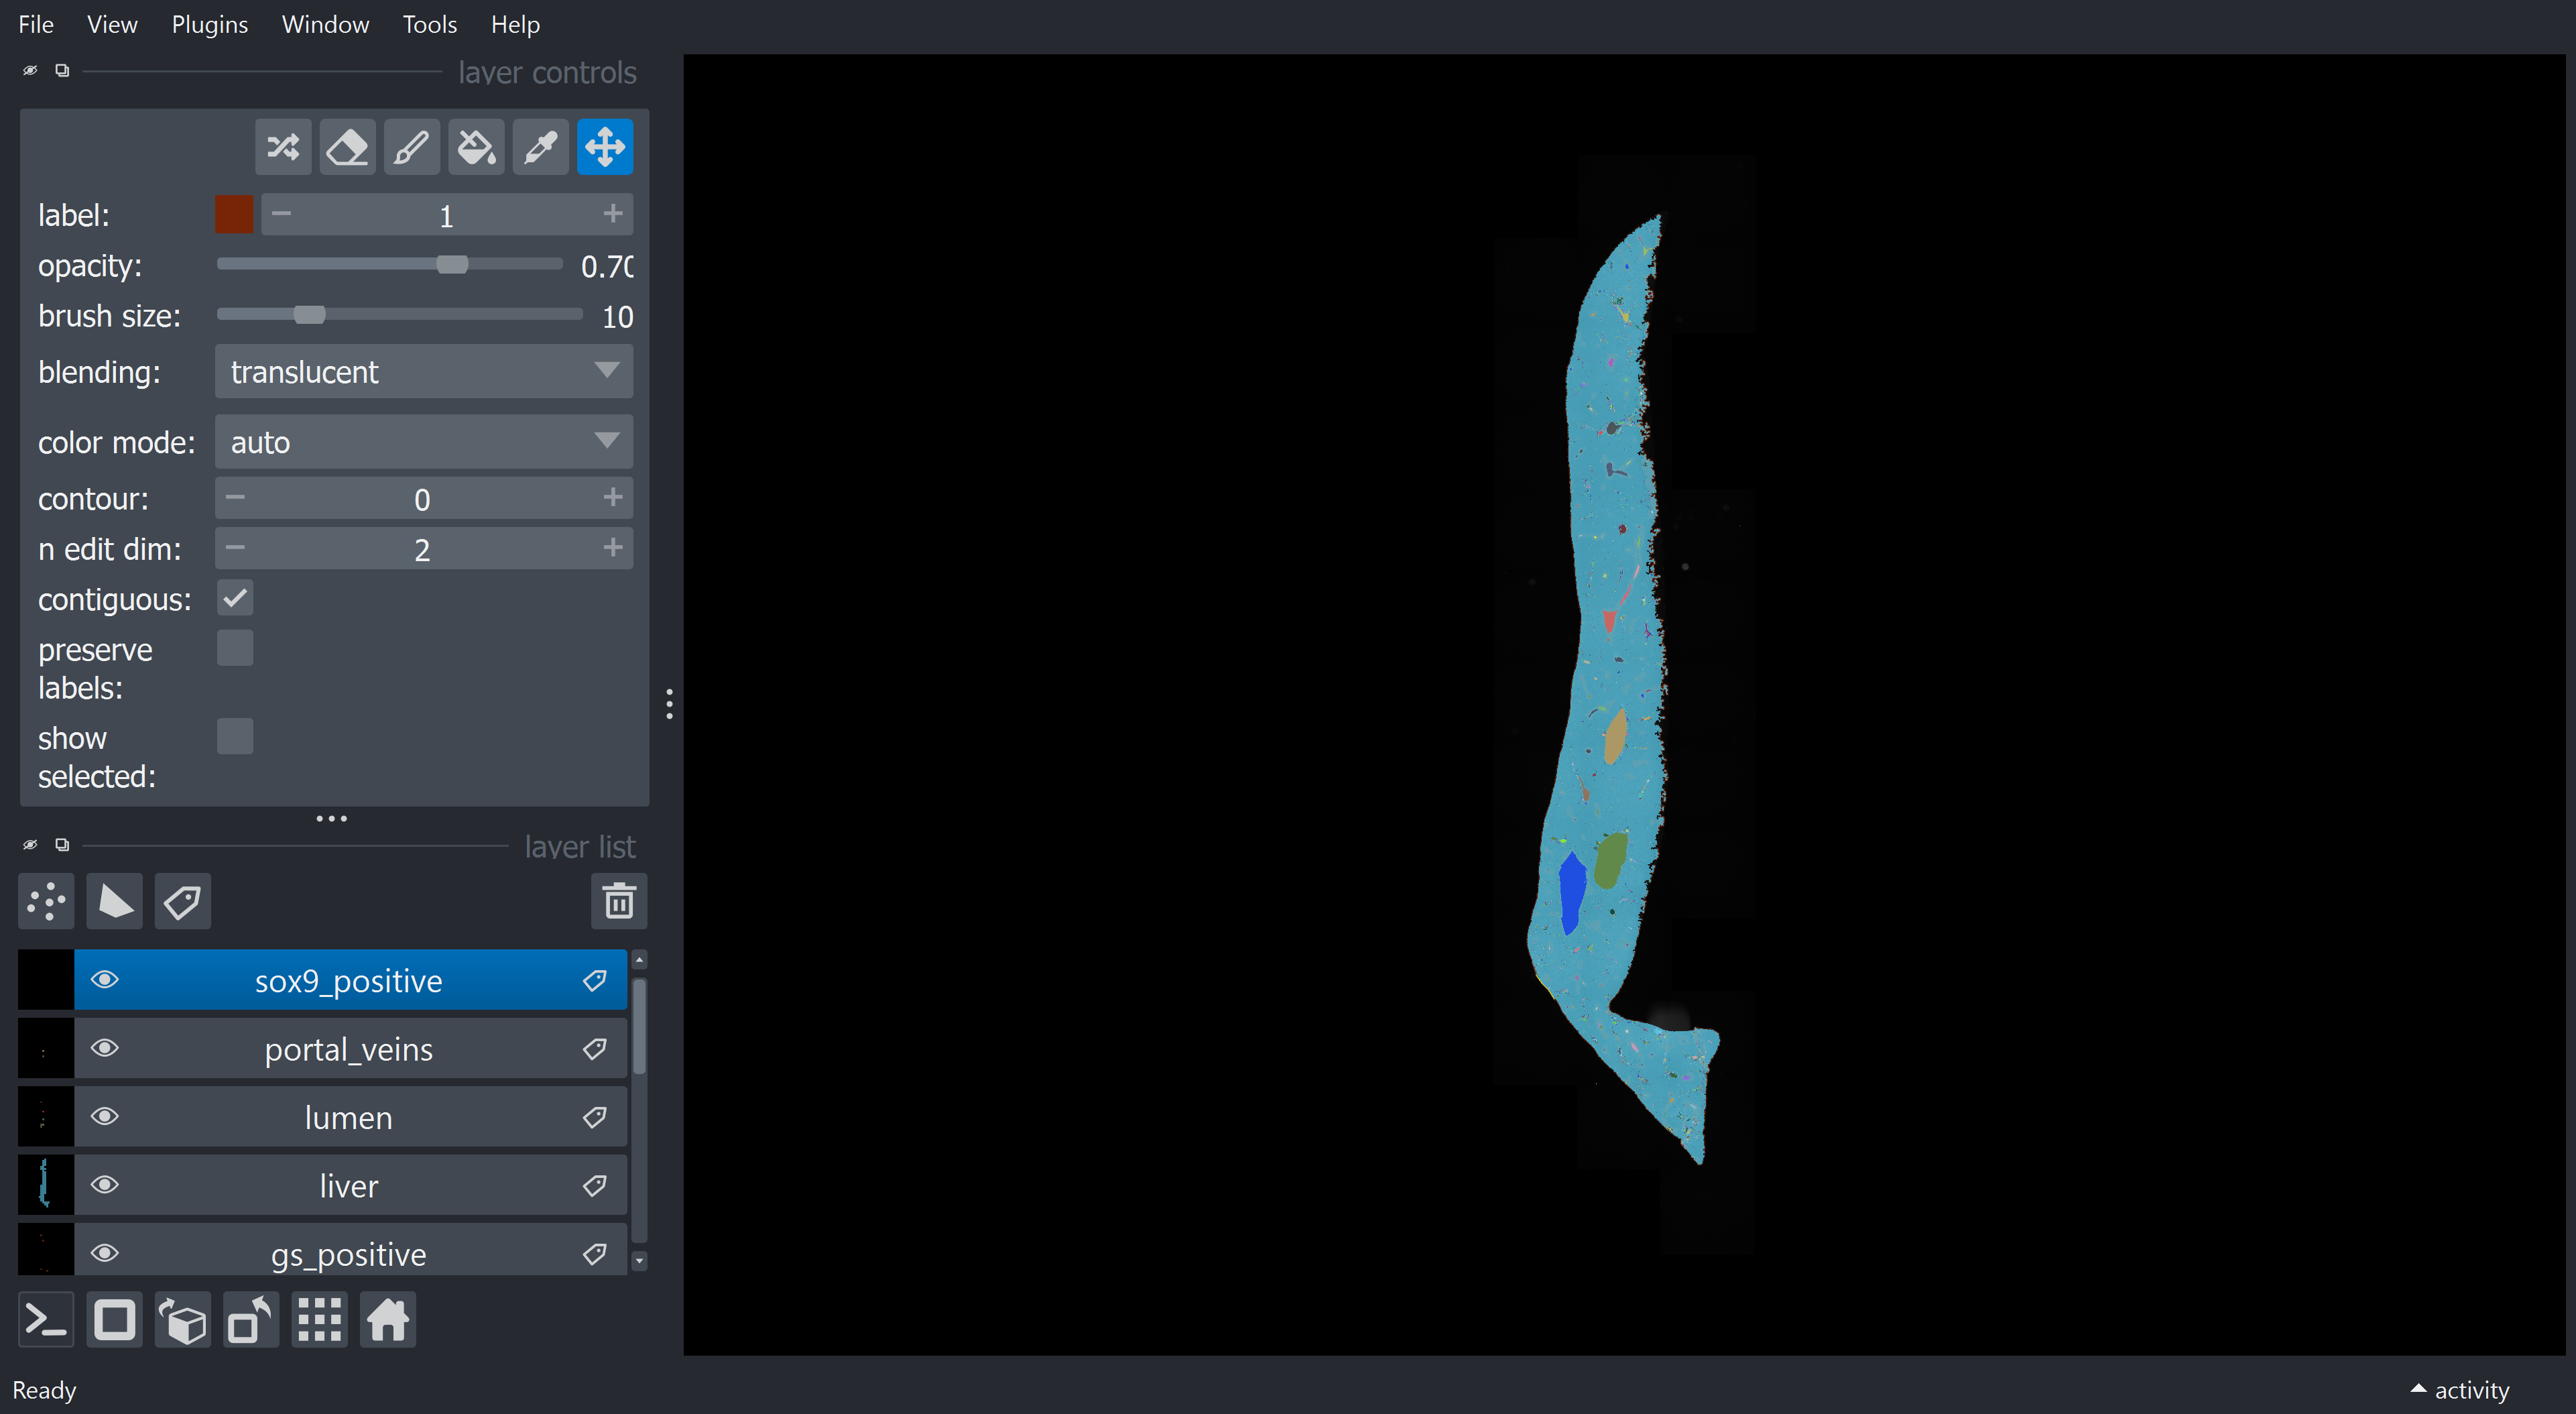

In [8]:
import napari

viewer = napari.Viewer()
viewer.add_image(sox9_channel, contrast_limits=(0, 2**16))
viewer.add_image(gs_channel, contrast_limits=(0, 2**16))
viewer.add_image(elastin_channel, contrast_limits=(0, 2**16))
for label_name, label_image in segmentations.items():
    viewer.add_labels(label_image["labels"][:], name=label_name)
napari.utils.nbscreenshot(viewer)

In [9]:
for label_name, label_image in segmentations.items():
    add_labels(image, label_image["labels"][:], label_name)

With these last step, every labeled image is added to the zarr file.